In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import math
from sklearn.metrics import average_precision_score, precision_recall_curve

from ete3 import NCBITaxa
from Bio import SeqIO
import taxoniq
import marisa_trie

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

### Bulk Analysis of Primary Benchmark results

This notebook focuses on the accuracy-related metrics from the Zymobiomics standard -- not used in any figures, but metrics are included in Table 1.

In [86]:
def generate_metrics(old_taxon_counts, new_taxon_counts, gold_standard, current_db, show_plots = True):

    '''
    This function generates all the metrics that we'll be using to assess differences between OLD and NEW sample runs.
    Metrics: Correlation, % Increase in Taxa, L2 Norm, Taxon counts
    '''

    old_df = pd.read_csv(old_taxon_counts)
    new_df = pd.read_csv(new_taxon_counts)
    try:
        #print("attempt to read GS")
        #print(gold_standard)
        gs = pd.read_csv(gold_standard, sep='\t')
    except:
        gs = None

    # select only the species-level taxon hits
    old_df = old_df[old_df.tax_level == 1][['tax_id', 'name', 'nt_bpm', 'nt_contigs', 'nr_bpm']]
    new_df = new_df[new_df.tax_level == 1][['tax_id', 'name', 'nt_bpm', 'nt_contigs', 'nr_bpm']]
  
    full_df = pd.merge(left = old_df, right = new_df, how='outer', on='tax_id', suffixes = ['_old', '_new'])
    
    full_df.dropna(subset=[(current_db+'_bpm_old'), (current_db+'_bpm_new')], how='all', inplace=True)
    full_df['log_'+current_db+'_bpm_old'] = np.log(full_df[current_db+'_bpm_old'] + 1)
    full_df['log_'+current_db+'_bpm_new'] = np.log(full_df[current_db+'_bpm_new'] + 1)

    full_df.sort_values(by=current_db+'_bpm_old', ascending = False, inplace=True)
    
    full_df.fillna(0, inplace=True)
    full_df['diff'] = full_df[current_db+'_bpm_old'] - full_df[current_db+'_bpm_new']
    full_df['max_' + current_db + '_bpm'] = full_df[[current_db+'_bpm_old', current_db+'_bpm_new']].max(axis=1)
    full_df['perc_diff'] = full_df['diff']/full_df['max_' + current_db+ '_bpm']

    full_df.sort_values(by='diff', inplace=True)
    top_diffs = full_df.head(5)
    bottom_diffs = full_df.tail(5)
    
    # optionally, generate scatterplots showing the taxon abundances of OLD v. NEW samples
    if(show_plots):
        full_df.plot(kind='scatter', x = current_db + '_bpm_old', y = current_db+'_bpm_new', alpha = .5, figsize=(5,5))
        plt.title(old_taxon_counts.split('/')[-1])
        for i in top_diffs.index:
            plt.text(x = top_diffs.loc[i][current_db +'_bpm_old'], y = top_diffs.loc[i][current_db + '_bpm_new'], s = top_diffs.loc[i]['name_new'], color='red') #'fixed_name'
        for i in bottom_diffs.index:
            plt.text(x = bottom_diffs.loc[i][current_db + '_bpm_old'], y = bottom_diffs.loc[i][current_db + '_bpm_new'], s = bottom_diffs.loc[i]['name_old'], color = 'blue')#, rotation=90)

        patches = [mpatches.Patch(color='red', label='top diffs'), mpatches.Patch(color='blue', label='bottom diffs')]
        plt.legend(handles=patches, loc='lower right', bbox_to_anchor=(1.4, .1))
        plt.show()

        full_df.plot(kind='scatter', x = 'log_' +  current_db +'_bpm_old', y = 'log_' + current_db + '_bpm_new', alpha = .5, figsize=(5,5))
        plt.title(old_taxon_counts.split('/')[-1])
        for i in top_diffs.index:
            plt.text(x = top_diffs.loc[i]['log_' + current_db + '_bpm_old'], y = top_diffs.loc[i]['log_' +  current_db+ '_bpm_new'], s = top_diffs.loc[i]['name_new'], color='red') #'fixed_name'
        for i in bottom_diffs.index:
            plt.text(x = bottom_diffs.loc[i]['log_' + current_db + '_bpm_old'], y = bottom_diffs.loc[i]['log_' + current_db + '_bpm_new'], s = bottom_diffs.loc[i]['name_old'], color='blue')

        plt.legend(handles=patches, loc='lower right', bbox_to_anchor=(1.4, .1))
        plt.show()
    
    new_organisms_df = full_df[full_df.nt_bpm_old == 0]
    new_organisms_df.sort_values(by=current_db + '_bpm_new', ascending = False, inplace=True)
    
    #overall correlation
    sc_total = np.round((stats.spearmanr(full_df[current_db + '_bpm_old'], full_df[current_db + '_bpm_new']))[0], 2)
    pc_total = np.round((stats.pearsonr(full_df[current_db + '_bpm_old'], full_df[current_db + '_bpm_new']))[0], 2)
    
    # correlation when removing the taxa that are new low-abundance hits -- 
    #    this being higher than the total correlation, means that the increase in "new taxa" (false-positives) is driving some of the spearman deviation
    full_df2 = full_df[full_df.nt_bpm_new > 10] #full_df[full_df.nt_bpm_old != 0]
    sc_top =np.round((stats.spearmanr(full_df2[current_db + '_bpm_old'], full_df2[current_db + '_bpm_new']))[0], 2)
    pc_top =np.round((stats.pearsonr(full_df2[current_db + '_bpm_old'], full_df2[current_db + '_bpm_new']))[0], 2)
    
    #sc_total_norm = spearman correlation of the normalized values
    sc_total_norm = np.round((stats.spearmanr(full_df[current_db + '_bpm_old']/sum(full_df[current_db + '_bpm_old']), 
                                         full_df[current_db + '_bpm_new']/sum(full_df[current_db + '_bpm_new'])))[0], 2)
    
    #l2_total = np.linalg.norm(np.log10(full_df[current_db + '_bpm_old']+1) - np.log10(full_df[current_db + '_bpm_new']+1))    
    l2_total = math.dist(full_df[current_db + '_bpm_old']/sum(full_df[current_db + '_bpm_old']), 
                         full_df[current_db + '_bpm_new']/sum(full_df[current_db + '_bpm_new'])) 
    
    # AUPR = the AUPR when taking the OLD results as the baseline.
    # https://sinyi-chou.github.io/python-sklearn-precision-recall/
    # average_precision = average_precision_score(baseline, new)
    aupr = average_precision_score(full_df[current_db + '_bpm_old'] > 0, 
                                                full_df[current_db + '_bpm_new']/sum(full_df[current_db + '_bpm_new']))
    
    res = {}
    for i in [0, 10, 100, 1000]:
        res[str(i)] = {}
        res[str(i)]['new'] = (full_df[current_db + '_bpm_new'] > i).sum()
        res[str(i)]['old'] = (full_df[current_db + '_bpm_old'] > i).sum()

    res_df = pd.DataFrame.from_dict(res, orient='index')

    if(show_plots):
        res_df.plot.bar()
        plt.title("Total Count of Hits, bpm > Threshold")
        plt.show()

    new_taxon_count = res['0']['new']
    old_taxon_count = res['0']['old']
    percent_increase = np.round(((new_taxon_count - old_taxon_count)/old_taxon_count)*100, 2)

    new_taxon_count_f = res['10']['new']
    old_taxon_count_f = res['10']['old']
    percent_increase_f = np.round(((new_taxon_count_f - old_taxon_count_f)/old_taxon_count_f)*100, 2)
    
    
    #try:
    if 'XXXX' not in gold_standard: # we do have a gold standard file for this, so should run analysis
        full_df_gs_old = pd.merge(left = old_df, right = gs, how='outer', on='tax_id', suffixes = ['_old', '_gs'])
        full_df_gs_old = full_df_gs_old[[current_db + '_bpm','abs_abundance', 'tax_id', 'name', 'tax_name']]
        full_df_gs_old.fillna(0, inplace=True)
        aupr_old = average_precision_score(full_df_gs_old['abs_abundance'] > 0, 
                                                full_df_gs_old[current_db + '_bpm'])
        
        l2_old = math.dist(full_df_gs_old['abs_abundance']/sum(full_df_gs_old['abs_abundance']), 
                         full_df_gs_old[current_db + '_bpm']/sum(full_df_gs_old[current_db + '_bpm'])) 
    
        #print(full_df_gs_old.head())
        #print('aupr_old')
        #print(aupr_old)
        
        full_df_gs_new = pd.merge(left = new_df, right = gs, how='outer', on='tax_id', suffixes = ['_new', '_gs'])
        full_df_gs_new = full_df_gs_new[[current_db + '_bpm','abs_abundance', 'tax_id', 'name', 'tax_name']]
        full_df_gs_new.fillna(0, inplace=True)
        aupr_new = average_precision_score(full_df_gs_new['abs_abundance'] > 0, 
                                                full_df_gs_new[current_db + '_bpm'])
        l2_new = math.dist(full_df_gs_new['abs_abundance']/sum(full_df_gs_new['abs_abundance']), 
                         full_df_gs_new[current_db + '_bpm']/sum(full_df_gs_new[current_db + '_bpm']))
        #print(full_df_gs_new.head())
        #print('aupr_new')
        #print(aupr_new)
        
        delta_aupr = aupr_new - aupr_old
        delta_l2 = l2_new - l2_old
        print('delta_aupr:')
        print(delta_aupr)
    else:
        # no gold standard file available, so don't run this analysis
        #except:
        #print("Gold Standard DOES NOT Exist")
        delta_aupr = 0
        delta_l2 = 0
    

    return({'sc_total': sc_total, 
           'pc_total': sc_total, 
           'sc_top': sc_top, 
           'pc_top': pc_top, 
            'sc_total_norm': sc_total_norm,
            'l2_total': l2_total,
            'aupr': aupr,
           'new_taxon_count': new_taxon_count, 
           'old_taxon_count': old_taxon_count, 
           'percent_increase': percent_increase,
           'new_taxon_count_f': new_taxon_count_f, 
           'old_taxon_count_f': old_taxon_count_f, 
           'percent_increase_f': percent_increase_f,
           'delta_aupr': delta_aupr,
           'delta_l2': delta_l2})

In [87]:
# INPUT FILES

# This manifest is intended to specify the input OLD v. NEW samples
manifest = {
            'zymobiomics': {'goldstandard': 'XXXX', 'old': "XXX.csv", 'new': "XXX.csv"},
        }

# This specifies which parameters were used in each set of pipeline runs
metadata_manifest = {
    'nt_nr_2021_01_22_compressed_0.7_scaled_1000.09_25_23': {'nr': 'nr-0.7-1000'},
    'nt_nr_2021_01_22_compressed_0.6_scaled_1000.09_25_23': {'nr': 'nr-0.6-1000'},
    '2023-09-15-nt-0.7-nr-0.7-scaled-100': {'nt': 'nt-0.7-1000', 'nr': 'nr-0.7-100'},
    '2023-09-15-nt-0.6-nr-0.6-scaled-100': {'nt': 'nt-0.6-1000', 'nr': 'nr-0.6-100'},
    'nt_2021_01_22_compressed_0.5_protein_scaled_1000': {'nt': 'nt-0.5-1000', 'nr': 'nr-0.5-1000'},
    'nt_2021_01_22_compressed_0-8_scaled_1000':{'nt': 'nt-0.8-1000', 'nr': 'nr-0.8-1000'},
    'nt_2021_01_22_compressed_0-9_scaled_1000':{'nt': 'nt-0.9-1000', 'nr': 'nr-0.9-1000'},
    '2023_10_18_no_compressed_nt_compressed_nr_k_31_thresh_0-8_scaled_100': {'nr': 'nr-0.8-100'},
    '2023_10_18_no_compressed_nt_compressed_nr_k_21_thresh_0-8_scaled_1000': {'nr': 'nr-0.8-1000-k21'}
}

# Run through each directory in the metadata manifest (each experiment) and calculate the metrics, formatting based on the relevant parameters

aggregate_metrics_dict = {}

for this_iteration in metadata_manifest.keys():
    
    for db in metadata_manifest[this_iteration].keys(): 
        
        print(this_iteration)
        print(db)
        aggregate_metrics_dict[metadata_manifest[this_iteration][db]] = {}
        
        current_db = db

        prefix_old = "./data/BASELINE/"
        prefix_new = "./data/NEW/" + this_iteration + "/"
        prefix_gs = "./data/GOLD_STANDARD/"

        final_metrics_dict = {}
        for i in manifest.keys():

            old_taxon_counts = prefix_old + manifest[i]["old"]
            new_taxon_counts = prefix_new + manifest[i]["new"]
            gold_standard = prefix_gs + manifest[i]["goldstandard"]

            final_metrics_dict[i] = generate_metrics(old_taxon_counts, new_taxon_counts, gold_standard, current_db, show_plots = False)

        final_metrics_df = pd.DataFrame.from_dict(final_metrics_dict, orient='index')
        final_metrics_df
        
        aggregate_metrics_dict[metadata_manifest[this_iteration][db]] = final_metrics_df


nt_nr_2021_01_22_compressed_0.7_scaled_1000.09_25_23
nr
delta_aupr:
-0.0007980018144914114


/Users/katrina.kalantar/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


delta_aupr:
-0.007734164262893417
delta_aupr:
0.0
delta_aupr:
0.0
delta_aupr:
-0.002080150968619021
nt_nr_2021_01_22_compressed_0.6_scaled_1000.09_25_23
nr
delta_aupr:
-0.000739002443818082
delta_aupr:
-0.008065568006065837
delta_aupr:
0.0
delta_aupr:
0.0
delta_aupr:
-0.001719400607868793
2023-09-15-nt-0.7-nr-0.7-scaled-100
nt
delta_aupr:
0.006256240870590402
delta_aupr:
0.0018963107593285011
delta_aupr:
0.0
delta_aupr:
-0.00029202745190470836
delta_aupr:
-0.0006719393004115393
2023-09-15-nt-0.7-nr-0.7-scaled-100
nr
delta_aupr:
-0.0035713010040404614
delta_aupr:
-0.01013337007127546
delta_aupr:
0.0
delta_aupr:
0.0
delta_aupr:
-0.006023548376645205
2023-09-15-nt-0.6-nr-0.6-scaled-100
nt
delta_aupr:
0.004028480207373897
delta_aupr:
0.0008523750364364258
delta_aupr:
0.0
delta_aupr:
-0.0003221445587314742
delta_aupr:
-0.003198263281814495
2023-09-15-nt-0.6-nr-0.6-scaled-100
nr
delta_aupr:
-0.0058017174098388136
delta_aupr:
-0.012150176334735363
delta_aupr:
0.0
delta_aupr:
0.0
delta_aupr:
-

### NOTE: Maybe delete all of the below since we aren't producing figures for this dataset

In [88]:
official_colors = ['#55efc4','#00b894', #greens 
                   '#81ecec','#00cec9', #teals
                   '#74b9ff','#0984e3', #blues
                   '#a29bfe','#6c5ce7', #purples
                   '#ffeaa7','#fdcb6e', #yellows
                   '#fab1a0', '#e17055', #oranges
                   '#ff7675', '#d63031', #reds
                   '#fd79a8', '#e84393', #pinks
                   '#dfe6e9', '#b2bec3', '#636e72', '#2d3436' #greys
                  ]

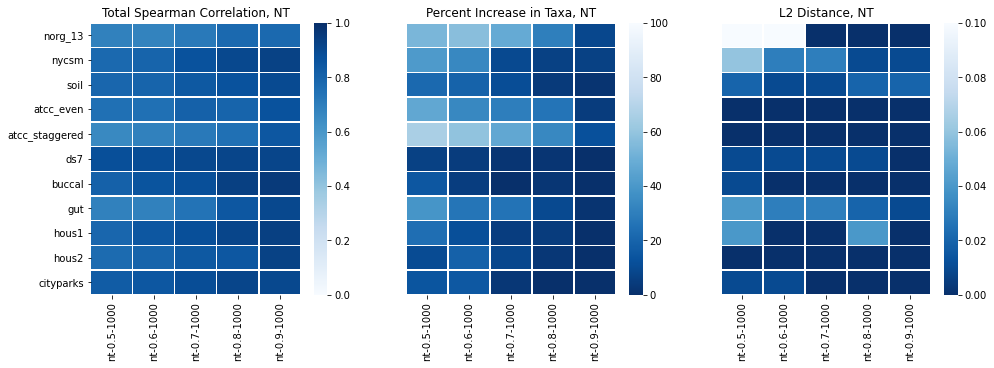

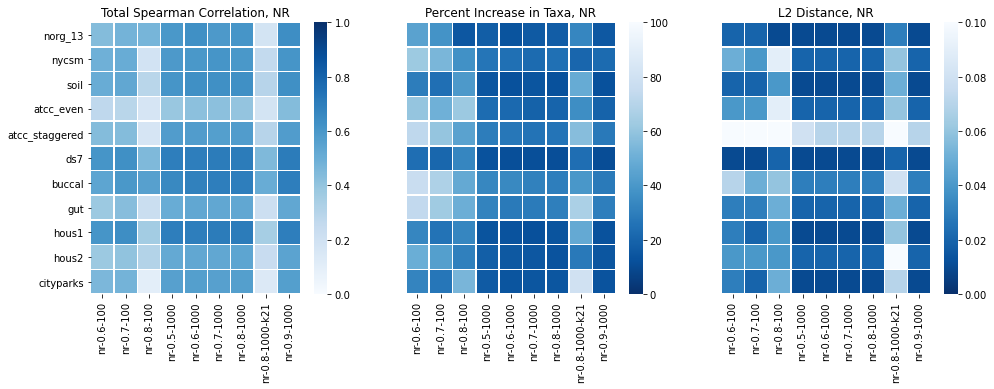

"# plot nt AUPR as heatmap\nnr_aupr_heatmap_data = {}\nfor i in aggregate_metrics_dict.keys():\n    if 'nr' in i:\n        nr_aupr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['aupr'])\n        \nnr_aupr_df = pd.DataFrame.from_dict(nr_aupr_heatmap_data)\nplot_heatmap(nr_aupr_df[column_order_nr], plot_type='aupr', this_title='AUPR, NR')\n"

In [89]:
# FIGURE S3 - Plot heatmaps for each metric, showing metrics across samples and parameters

column_order_nt = ['nt-0.5-1000', 'nt-0.6-1000', 'nt-0.7-1000', 'nt-0.8-1000', 'nt-0.9-1000']
column_order_nr = [ 'nr-0.6-100', 'nr-0.7-100', 'nr-0.8-100', 'nr-0.5-1000', 'nr-0.6-1000', 'nr-0.7-1000', 
                   'nr-0.8-1000', 'nr-0.8-1000-k21', 'nr-0.9-1000']

def plot_heatmap(input_df, plot_type, this_title):
    
    if plot_type == 'corr':
        this_vmax = 1
        this_vmin = 0
        cpal = sns.color_palette("Blues", as_cmap=True)
    elif plot_type == 'pct':
        this_vmax = 100
        this_vmin = 0 #-100
        cpal = sns.color_palette("Blues_r", as_cmap=True) #"RdBu_r"
    elif plot_type == 'l2':
        this_vmax = .1
        this_vmin = 0
        cpal = sns.color_palette("Blues_r", as_cmap=True)
    elif plot_type == 'aupr':
        this_vmax = 1
        this_vmin = 0
        cpal = sns.color_palette("Blues_r", as_cmap=True)
    
    sns.heatmap(input_df, vmax = this_vmax, vmin = this_vmin, cmap=cpal, linewidths=.5, linecolor='white', annot=False)#,figsize=(4,5))
    plt.title(this_title)
    #plt.show()

plt.figure(figsize=(16,5))

# plot nt correlation as heatmap
plt.subplot(1, 3, 1)
nt_corr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_corr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['sc_total'])
nt_corr_df = pd.DataFrame.from_dict(nt_corr_heatmap_data)
plot_heatmap(nt_corr_df[column_order_nt], plot_type='corr', this_title='Total Spearman Correlation, NT')

# plot nt pct_inc as heatmap
plt.subplot(1, 3, 2)
nt_pctinc_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_pctinc_heatmap_data[i] = dict(aggregate_metrics_dict[i]['percent_increase'])        
nt_pctinc_df = pd.DataFrame.from_dict(nt_pctinc_heatmap_data)
plot_heatmap(np.round(nt_pctinc_df[column_order_nt],2), plot_type='pct', this_title='Percent Increase in Taxa, NT')
plt.yticks([])

# plot nt L2 as heatmap
plt.subplot(1, 3, 3)
nt_l2_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_l2_heatmap_data[i] = dict(aggregate_metrics_dict[i]['l2_total'])
nt_l2_df = pd.DataFrame.from_dict(nt_l2_heatmap_data)
plot_heatmap(np.round(nt_l2_df[column_order_nt],2), plot_type='l2', this_title='L2 Distance, NT')
plt.yticks([])

plt.show()

'''# plot nt AUPR as heatmap
nt_aupr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_aupr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['aupr'])
        
nt_aupr_df = pd.DataFrame.from_dict(nt_aupr_heatmap_data)
plot_heatmap(nt_aupr_df[column_order_nt], plot_type='aupr', this_title='AUPR, NT')
'''

plt.figure(figsize=(16,5))

# plot nr correlation as heatmap
plt.subplot(1, 3, 1)
nr_corr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_corr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['sc_total'])
nr_corr_df = pd.DataFrame.from_dict(nr_corr_heatmap_data)
nr_corr_df
plot_heatmap(nr_corr_df[column_order_nr], plot_type='corr', this_title='Total Spearman Correlation, NR')


# plot nr pct_inc as heatmap
plt.subplot(1, 3, 2)
nr_pctinc_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_pctinc_heatmap_data[i] = dict(aggregate_metrics_dict[i]['percent_increase'])
nr_pctinc_df = pd.DataFrame.from_dict(nr_pctinc_heatmap_data)
plot_heatmap(np.round(nr_pctinc_df[column_order_nr],2), plot_type='pct', this_title='Percent Increase in Taxa, NR')
plt.yticks([])

# plot nr L2 as heatmap
plt.subplot(1, 3, 3)
nr_l2_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_l2_heatmap_data[i] = dict(aggregate_metrics_dict[i]['l2_total'])
        
nr_l2_df = pd.DataFrame.from_dict(nr_l2_heatmap_data)
plot_heatmap(np.round(nr_l2_df[column_order_nr],2), plot_type='l2', this_title='L2 Distance, NR')
plt.yticks([])

plt.show()

'''# plot nt AUPR as heatmap
nr_aupr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_aupr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['aupr'])
        
nr_aupr_df = pd.DataFrame.from_dict(nr_aupr_heatmap_data)
plot_heatmap(nr_aupr_df[column_order_nr], plot_type='aupr', this_title='AUPR, NR')
'''



norg_13           0.000000
nycsm             0.000000
soil              0.002463
atcc_even         0.000000
atcc_staggered    0.000000
ds7               0.000607
buccal            0.000000
gut               0.000000
hous1             0.000000
hous2            -0.000123
cityparks         0.000343
Name: delta_aupr, dtype: float64
norg_13           0.000000
nycsm             0.000000
soil             -0.000508
atcc_even         0.000000
atcc_staggered    0.000000
ds7              -0.006895
buccal            0.000000
gut               0.000000
hous1             0.000000
hous2             0.000000
cityparks        -0.002127
Name: delta_aupr, dtype: float64


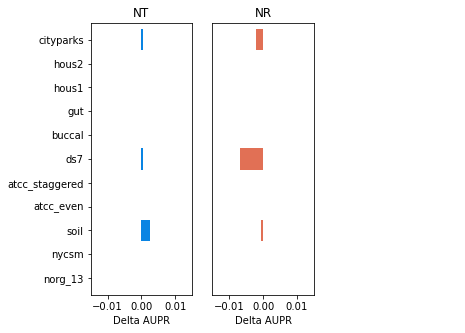

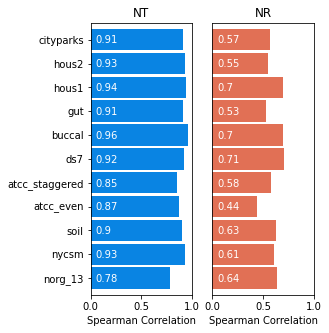

Text(0.5, 1.0, 'NR')

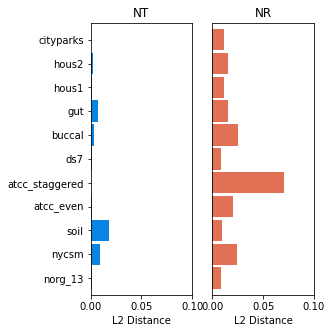

In [90]:
# FIGURE 2A, 2B, and 2C - For a specified parameterization, plot the key metrics to be shown alongside the main text

selected_nt = 'nt-0.9-1000'
selected_nr = 'nr-0.9-1000'

this_data_nt = aggregate_metrics_dict[selected_nt]
this_data_nt.drop(['norg_13'])
this_data_nr = aggregate_metrics_dict[selected_nr]
this_data_nr.drop(['norg_13'])


plt.subplot(1, 2, 1)
print(this_data_nt['delta_aupr'])
this_data_nt['delta_aupr'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(-.015,.015), color=official_colors[5])
plt.xlabel('Delta AUPR')
plt.title('NT')
for i, v in enumerate(this_data_nt['delta_aupr']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.subplot(1, 2, 2)
print(this_data_nr['delta_aupr'])
this_data_nr['delta_aupr'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(-.015,.015), color=official_colors[11])
plt.xlabel('Delta AUPR')
plt.title('NR')
plt.yticks([])
for i, v in enumerate(this_data_nr['delta_aupr']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.show()



plt.subplot(1, 2, 1)
this_data_nt['sc_total'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(0,1), color=official_colors[5])
plt.xlabel('Spearman Correlation')
plt.title('NT')
for i, v in enumerate(this_data_nt['sc_total']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.subplot(1, 2, 2)
this_data_nr['sc_total'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(0,1), color=official_colors[11])
plt.xlabel('Spearman Correlation')
plt.title('NR')
plt.yticks([])
for i, v in enumerate(this_data_nr['sc_total']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.show()


plt.subplot(1, 2, 1)
this_data_nt['l2_total'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(0,.1), color = official_colors[5])
plt.xlabel('L2 Distance')
plt.title('NT')
#for i, v in enumerate(this_data_nt['l2_total']):
#    plt.text(0.01, i - .15, str(np.round(v,2)), color='black')

plt.subplot(1, 2, 2)
this_data_nr['l2_total'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(0,.1), color=official_colors[11])
plt.yticks([])
plt.xlabel('L2 Distance')
plt.title('NR')
#for i, v in enumerate(this_data_nr['l2_total']):
#    plt.text(0.01, i - .15, str(np.round(v,2)), color='black')


In [91]:
'''# DRAFT - potential way to show heatmap data as a series of boxplots -- this highlights the comparisons more, but loses the dataset-specific information

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
nt_corr_df[column_order_nt].boxplot(showfliers=False, color='black')
for i, d in enumerate(nt_corr_df[column_order_nt]):
    y = nt_corr_df[column_order_nt][d]
    x = np.random.normal(i + 1, 0.08, len(y))
    plt.scatter(x, y, color = 'blue', alpha=.5)
plt.grid(False)

plt.subplot(1, 3, 2)
nt_pctinc_df[column_order_nt].boxplot(showfliers=False, color='black')
for i, d in enumerate(nt_pctinc_df[column_order_nt]):
    y = nt_pctinc_df[column_order_nt][d]
    x = np.random.normal(i + 1, 0.08, len(y))
    plt.scatter(x, y, color = 'blue', alpha=.5)
plt.grid(False)

plt.subplot(1, 3, 3)
nt_l2_df[column_order_nt].boxplot(showfliers=False, color='black')
for i, d in enumerate(nt_l2_df[column_order_nt]):
    y = nt_l2_df[column_order_nt][d]
    x = np.random.normal(i + 1, 0.08, len(y))
    plt.scatter(x, y, color = 'blue', alpha=.5)
plt.grid(False)'''

"# DRAFT - potential way to show heatmap data as a series of boxplots -- this highlights the comparisons more, but loses the dataset-specific information\n\nplt.figure(figsize=(15,5))\n\nplt.subplot(1, 3, 1)\nnt_corr_df[column_order_nt].boxplot(showfliers=False, color='black')\nfor i, d in enumerate(nt_corr_df[column_order_nt]):\n    y = nt_corr_df[column_order_nt][d]\n    x = np.random.normal(i + 1, 0.08, len(y))\n    plt.scatter(x, y, color = 'blue', alpha=.5)\nplt.grid(False)\n\nplt.subplot(1, 3, 2)\nnt_pctinc_df[column_order_nt].boxplot(showfliers=False, color='black')\nfor i, d in enumerate(nt_pctinc_df[column_order_nt]):\n    y = nt_pctinc_df[column_order_nt][d]\n    x = np.random.normal(i + 1, 0.08, len(y))\n    plt.scatter(x, y, color = 'blue', alpha=.5)\nplt.grid(False)\n\nplt.subplot(1, 3, 3)\nnt_l2_df[column_order_nt].boxplot(showfliers=False, color='black')\nfor i, d in enumerate(nt_l2_df[column_order_nt]):\n    y = nt_l2_df[column_order_nt][d]\n    x = np.random.normal(i +

In [103]:
# TODO - figure out how to make this printf work! 
# TODO - text says "regardless of sequencing technology" which would require making this whole script compatible with the zymobiomics sample

printf("NT Delta AUPR range: %f - %f", np.min(this_data_nt['delta_aupr']), np.max(this_data_nt['delta_aupr']))
printf("NT Delta L2 range: %f - %f", np.min(this_data_nt['delta_l2']), np.max(this_data_nt['delta_l2']))

printf("NR Delta AUPR range: %f - %f", np.min(this_data_nr['delta_aupr']), np.max(this_data_nr['delta_aupr']))
printf("NR Delta L2 range: %f - %f", np.min(this_data_nr['delta_l2']), np.max(this_data_nr['delta_l2']))



printf("(NT) average spearman correlation %f (SD = %f)", np.mean(this_data_nt['sc_total']), np.std(this_data_nt['sc_total']))
printf("(NR) average spearman correlation %f (SD = %f)", np.mean(this_data_nr['sc_total']), np.std(this_data_nr['sc_total']))

printf("L2 distances remained low ( < %f for NT, %f for NR)", np.max(this_data_nt['l2_total']), np.max(this_data_nr['l2_total']))


NameError: name 'printf' is not defined